### importing Libraries

In [74]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import Normalizer
import pickle
from tqdm import tqdm
import os
from prettytable import PrettyTable
import csv
import math
from chart_studio import plotly
import plotly.offline as offline
import plotly.graph_objs as go
offline.init_notebook_mode()
from collections import Counter

In [75]:
data=pd.read_csv("preprocessed_data.csv")
data.head()

school_state teacher_prefix project_grade_category  \
0           ca            mrs          grades_prek_2   
1           ut             ms             grades_3_5   
2           ca            mrs          grades_prek_2   
3           ga            mrs          grades_prek_2   
4           wa            mrs             grades_3_5   

   teacher_number_of_previously_posted_projects  project_is_approved  \
0                                            53                    1   
1                                             4                    1   
2                                            10                    1   
3                                             2                    1   
4                                             2                    1   

    clean_categories                 clean_subcategories  \
0       math_science  appliedsciences health_lifescience   
1       specialneeds                        specialneeds   
2  literacy_language                            literacy   
3    appliedlearning                    earlydevelopment   
4  literacy_language                            literacy   

                                               essay   price  
0  i fortunate enough use fairy tale stem kits cl...  725.05  
1  imagine 8 9 years old you third grade classroo...  213.03  
2  having class 24 students comes diverse learner...  329.00  
3  i recently read article giving students choice...  481.04  
4  my students crave challenge eat obstacles brea...   17.74

### Sentiment Analysis:

In [76]:
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
sent_int = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\sarav\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [77]:
# https://analyticsindiamag.com/sentiment-analysis-made-easy-using-vader/#:~:text=The%20compound%20score%20is%20the,%25%20Negative%2C%2050.8%25%20Neutral.

negative = []
positive = []
neutral = []
compound = []

def update_sentiments(values):
    negative.append(values["neg"])    
    positive.append(values["pos"])
    neutral.append(values["neu"])
    compound.append(values["compound"])

In [78]:
from tqdm import tqdm
for essay in tqdm(data["essay"]):
    update_sentiments(sent_int.polarity_scores(essay))

100%|█████████████████████████████████████████████████████████████████████████| 109248/109248 [08:00<00:00, 227.45it/s]


In [ ]:
data["negative"] = negative
data["positive"] = positive
data["neutral"] = neutral
data["compound"] = compound

In [80]:
data.head()

school_state teacher_prefix project_grade_category  \
0           ca            mrs          grades_prek_2   
1           ut             ms             grades_3_5   
2           ca            mrs          grades_prek_2   
3           ga            mrs          grades_prek_2   
4           wa            mrs             grades_3_5   

   teacher_number_of_previously_posted_projects  project_is_approved  \
0                                            53                    1   
1                                             4                    1   
2                                            10                    1   
3                                             2                    1   
4                                             2                    1   

    clean_categories                 clean_subcategories  \
0       math_science  appliedsciences health_lifescience   
1       specialneeds                        specialneeds   
2  literacy_language                            literacy   
3    appliedlearning                    earlydevelopment   
4  literacy_language                            literacy   

                                               essay   price    neg    pos  \
0  i fortunate enough use fairy tale stem kits cl...  725.05  0.013  0.205   
1  imagine 8 9 years old you third grade classroo...  213.03  0.072  0.248   
2  having class 24 students comes diverse learner...  329.00  0.017  0.262   
3  i recently read article giving students choice...  481.04  0.030  0.187   
4  my students crave challenge eat obstacles brea...   17.74  0.029  0.288   

     neu  compound  
0  0.783    0.9867  
1  0.680    0.9897  
2  0.721    0.9860  
3  0.783    0.9524  
4  0.683    0.9873

In [81]:
y=data['project_is_approved'].values
data.drop(['project_is_approved'],axis='columns',inplace=True)
X=data

### Splitting dataset:

In [82]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, stratify=y,random_state=42) 
print(len(X_train))
print(len(X_test))

73196
36052


### TFIDF VECTORIZATION

In [83]:
vect_tfidf_1 = TfidfVectorizer(min_df=10, ngram_range=(1,4), max_features=5000)
def TFIDF_Vectorization(train_column, test_column):
    vect_tfidf_1.fit(train_column)
    X_train_tfidf = vect_tfidf_1.transform(train_column)
    X_test_tfidf = vect_tfidf_1.transform(test_column)
    return (X_train_tfidf, X_test_tfidf)

In [84]:
train1 = X_train['essay'].values
test1=X_test['essay'].values
X_train_essay,X_test_essay = tqdm(TFIDF_Vectorization(train1,test1))
print("After vectorizations")
print(X_train_essay.shape, y_train.shape)
print(X_test_essay.shape, y_test.shape)

100%|████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<?, ?it/s]

After vectorizations
(73196, 5000) (73196,)
(36052, 5000) (36052,)


### TFIDF W2V

In [85]:
###http://www.jessicayung.com/how-to-use-pickle-to-save-and-load-variables-in-python/

import pickle
with open (r'glove_vectors', "rb") as f:
    model = pickle.load(f)
    glove_words = set(model.keys())

### TFIDF W2V on Train data

In [86]:
tfidf_model = TfidfVectorizer()
tfidf_model.fit(X_train['essay'])
tfidf_feat=tfidf_model.get_feature_names()
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(tfidf_model.get_feature_names(), list(tfidf_model.idf_)))
tfidf_words = set(tfidf_model.get_feature_names())

In [87]:
## https://medium.com/analytics-vidhya/featurization-of-text-data-bow-tf-idf-avgw2v-tfidf-weighted-w2v-7a6c62e8b097#:~:text=TFIDF%20weighted%20Word2Vec,sum%20by%20sum%20tfidf%20value.

train_tfidf_w2v_vectors = [];
for sentence in tqdm(X_train['essay']):
    vector = np.zeros(300)
    tf_idf_weight =0;
    for word in sentence.split(): 
        if (word in glove_words) and (word in tfidf_words):
            vec = model[word] 
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split()))
            vector += (vec * tf_idf) 
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    train_tfidf_w2v_vectors.append(vector)
train_tfidf_w2v_vectors=np.array(train_tfidf_w2v_vectors)

print(len(train_tfidf_w2v_vectors))
print(len(train_tfidf_w2v_vectors[0]))

100%|███████████████████████████████████████████████████████████████████████████| 73196/73196 [06:57<00:00, 175.16it/s]


73196
300


### TFIDF W2V on Test data

In [88]:
test_tfidf_w2v_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(X_test['essay']):
    vector = np.zeros(300)
    tf_idf_weight =0;
    for word in sentence.split(): 
        if (word in glove_words) and (word in tfidf_words):
            vec = model[word] 
            
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) 
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    test_tfidf_w2v_vectors.append(vector)
test_tfidf_w2v_vectors=np.array(test_tfidf_w2v_vectors)

print(len(test_tfidf_w2v_vectors))
print(len(test_tfidf_w2v_vectors[0]))

100%|███████████████████████████████████████████████████████████████████████████| 36052/36052 [02:01<00:00, 295.88it/s]


36052
300


### Encoding catgorical data:

In [89]:
def categorical_data(train_value,test_value):
    vectorizer=CountVectorizer()
    vectorizer.fit(train_value)
    X_train_transform=vectorizer.transform(train_value)
    X_test_transform=vectorizer.transform(test_value)
    feature_name=vectorizer.get_feature_names()
    return X_train_transform,X_test_transform,feature_name

### School_state:

In [90]:
train2=X_train['school_state'].values
test2=X_test['school_state'].values
X_train_state_transform,X_test_state_transform,feature2 = categorical_data(train2,test2)
print("After vectorizations")
print(X_train_state_transform.shape, y_train.shape)
print(X_test_state_transform.shape, y_test.shape)
print(feature2)

After vectorizations
(73196, 51) (73196,)
(36052, 51) (36052,)
['ak', 'al', 'ar', 'az', 'ca', 'co', 'ct', 'dc', 'de', 'fl', 'ga', 'hi', 'ia', 'id', 'il', 'in', 'ks', 'ky', 'la', 'ma', 'md', 'me', 'mi', 'mn', 'mo', 'ms', 'mt', 'nc', 'nd', 'ne', 'nh', 'nj', 'nm', 'nv', 'ny', 'oh', 'ok', 'or', 'pa', 'ri', 'sc', 'sd', 'tn', 'tx', 'ut', 'va', 'vt', 'wa', 'wi', 'wv', 'wy']


### Teacher_prefix:

In [91]:
train3=X_train['teacher_prefix'].values
test3=X_test['teacher_prefix'].values
X_train_prefix_transform,X_test_prefix_transform,feature3 = categorical_data(train3,test3)
print("After vectorizations")
print(X_train_prefix_transform.shape, y_train.shape)
print(X_test_prefix_transform.shape, y_test.shape)
print(feature3)

After vectorizations
(73196, 5) (73196,)
(36052, 5) (36052,)
['dr', 'mr', 'mrs', 'ms', 'teacher']


### Project_grade_category:

In [92]:
train4=X_train['project_grade_category'].values
test4=X_test['project_grade_category'].values
X_train_grade_transform,X_test_grade_transform,feature4 = categorical_data(train4,test4)
print("After vectorizations")
print(X_train_grade_transform.shape, y_train.shape)
print(X_test_grade_transform.shape, y_test.shape)
print(feature4)

After vectorizations
(73196, 4) (73196,)
(36052, 4) (36052,)
['grades_3_5', 'grades_6_8', 'grades_9_12', 'grades_prek_2']


### Clean_category:

In [93]:
train5=X_train['clean_categories'].values
test5=X_test['clean_categories'].values
X_train_categories_transform,X_test_categories_transform,feature5 = categorical_data(train5,test5)
print("After vectorizations")
print(X_train_categories_transform.shape, y_train.shape)
print(X_test_categories_transform.shape, y_test.shape)
print(feature5)

After vectorizations
(73196, 9) (73196,)
(36052, 9) (36052,)
['appliedlearning', 'care_hunger', 'health_sports', 'history_civics', 'literacy_language', 'math_science', 'music_arts', 'specialneeds', 'warmth']


### Clean_subcategory:

In [94]:
train6=X_train['clean_subcategories'].values
test6=X_test['clean_subcategories'].values
X_train_sub_transform,X_test_sub_transform,feature6 = categorical_data(train6,test6)
print("After vectorizations")
print(X_train_sub_transform.shape, y_train.shape)
print(X_test_sub_transform.shape, y_test.shape)
print(feature6)

After vectorizations
(73196, 30) (73196,)
(36052, 30) (36052,)
['appliedsciences', 'care_hunger', 'charactereducation', 'civics_government', 'college_careerprep', 'communityservice', 'earlydevelopment', 'economics', 'environmentalscience', 'esl', 'extracurricular', 'financialliteracy', 'foreignlanguages', 'gym_fitness', 'health_lifescience', 'health_wellness', 'history_geography', 'literacy', 'literature_writing', 'mathematics', 'music', 'nutritioneducation', 'other', 'parentinvolvement', 'performingarts', 'socialsciences', 'specialneeds', 'teamsports', 'visualarts', 'warmth']


### Encoding numerical data:

In [95]:
def numerical_data(train_value,test_value):
    normalizer=Normalizer()
    normalizer.fit(train_value)
    X_train_transform_norm=normalizer.transform(train_value)
    X_test_transform_norm=normalizer.transform(test_value)
    return X_train_transform_norm,X_test_transform_norm

### Price:

In [96]:
train7=X_train['price'].values.reshape(-1,1)
test7=X_test['price'].values.reshape(-1,1)
X_train_price_transform,X_test_price_transform = numerical_data(train7,test7)
print("After vectorizations")
print(X_train_price_transform.shape, y_train.shape)
print(X_test_price_transform.shape, y_test.shape)

After vectorizations
(73196, 1) (73196,)
(36052, 1) (36052,)


### teacher_number_of_previously_posted_projects:

In [97]:
train8=X_train['teacher_number_of_previously_posted_projects'].values.reshape(-1,1)
test8=X_test['teacher_number_of_previously_posted_projects'].values.reshape(-1,1)
X_train_prev_transform,X_test_prev_transform = numerical_data(train8,test8)
print("After vectorizations")
print(X_train_prev_transform.shape, y_train.shape)
print(X_test_prev_transform.shape, y_test.shape)

After vectorizations
(73196, 1) (73196,)
(36052, 1) (36052,)


### Negative sentiment:

In [98]:
train9=X_train['neg'].values.reshape(-1,1)
test9=X_test['neg'].values.reshape(-1,1)
X_train_neg,X_test_neg = numerical_data(train9,test9)
print("After vectorizations")
print(X_train_neg.shape, y_train.shape)
print(X_test_neg.shape, y_test.shape)

After vectorizations
(73196, 1) (73196,)
(36052, 1) (36052,)


### positive sentiment:

In [99]:
train10=X_train['pos'].values.reshape(-1,1)
test10=X_test['pos'].values.reshape(-1,1)
X_train_pos,X_test_pos = numerical_data(train10,test10)
print("After vectorizations")
print(X_train_pos.shape, y_train.shape)
print(X_test_pos.shape, y_test.shape)

After vectorizations
(73196, 1) (73196,)
(36052, 1) (36052,)


### Neutral sentiment:

In [100]:
train11=X_train['neu'].values.reshape(-1,1)
test11=X_test['neu'].values.reshape(-1,1)
X_train_neu,X_test_neu = numerical_data(train11,test11)
print("After vectorizations")
print(X_train_neu.shape, y_train.shape)
print(X_test_neu.shape, y_test.shape)

After vectorizations
(73196, 1) (73196,)
(36052, 1) (36052,)


### Compound of sentiment:

In [101]:
train12=X_train['compound'].values.reshape(-1,1)
test12=X_test['compound'].values.reshape(-1,1)
X_train_compound,X_test_compound = numerical_data(train12,test12)
print("After vectorizations")
print(X_train_compound.shape, y_train.shape)
print(X_test_compound.shape, y_test.shape)

After vectorizations
(73196, 1) (73196,)
(36052, 1) (36052,)


### Stacking of features:

In [102]:
from scipy.sparse import hstack
X_train_set1=hstack((X_train_state_transform, \
                   X_train_prefix_transform, \
                   X_train_grade_transform, \
                   X_train_categories_transform, \
                   X_train_sub_transform, \
                   X_train_price_transform, \
                   X_train_prev_transform, \
                   X_train_essay, \
                   X_train_compound, \
                    X_train_neu, \
                    X_train_pos, \
                    X_train_neg)).tocsr()
X_test_set1=hstack((X_test_state_transform, \
                   X_test_prefix_transform, \
                   X_test_grade_transform, \
                   X_test_categories_transform, \
                   X_test_sub_transform, \
                   X_test_price_transform, \
                   X_test_prev_transform, \
                   X_test_essay, \
                   X_test_compound, \
                   X_test_pos, \
                   X_test_neg, \
                   X_test_neu)).tocsr()

In [103]:
from scipy.sparse import hstack
X_train_set2=hstack((X_train_state_transform, \
                   X_train_prefix_transform, \
                   X_train_grade_transform, \
                   X_train_categories_transform, \
                   X_train_sub_transform, \
                   X_train_price_transform, \
                   X_train_prev_transform, \
                   train_tfidf_w2v_vectors, \
                   X_train_compound, \
                    X_train_neu, \
                    X_train_pos, \
                    X_train_neg)).tocsr()
X_test_set2=hstack((X_test_state_transform, \
                   X_test_prefix_transform, \
                   X_test_grade_transform, \
                   X_test_categories_transform, \
                   X_test_sub_transform, \
                   X_test_price_transform, \
                   X_test_prev_transform, \
                   test_tfidf_w2v_vectors, \
                   X_test_compound, \
                   X_test_pos, \
                   X_test_neg, \
                   X_test_neu)).tocsr()

### Model Implementation:

In [195]:
## https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html

from sklearn import tree
Dtree = tree.DecisionTreeClassifier(class_weight ="balanced")
from sklearn.model_selection import GridSearchCV
params={"max_depth":[1, 3, 10, 30],"min_samples_split":[5, 10, 100, 500]}
GCV = GridSearchCV(Dtree,params,cv=5,return_train_score=True,scoring='roc_auc',n_jobs=-1)
GCV.fit(X_train_set1,y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(class_weight='balanced'),
             n_jobs=-1,
             param_grid={'max_depth': [1, 3, 10, 30],
                         'min_samples_split': [5, 10, 100, 500]},
             return_train_score=True, scoring='roc_auc')

### Best parameters:

In [196]:
trainauc= GCV.cv_results_['mean_train_score']
trainaucstd= GCV.cv_results_['std_train_score']
cvauc1 = GCV.cv_results_['mean_test_score'] 
cvaucstd1= GCV.cv_results_['std_test_score']
print('Best score: ',GCV.best_score_)
print('Best Hyper params: ',GCV.best_params_)

Best score:  0.6293731142535497
Best Hyper params:  {'max_depth': 10, 'min_samples_split': 500}


### Heat Maps:

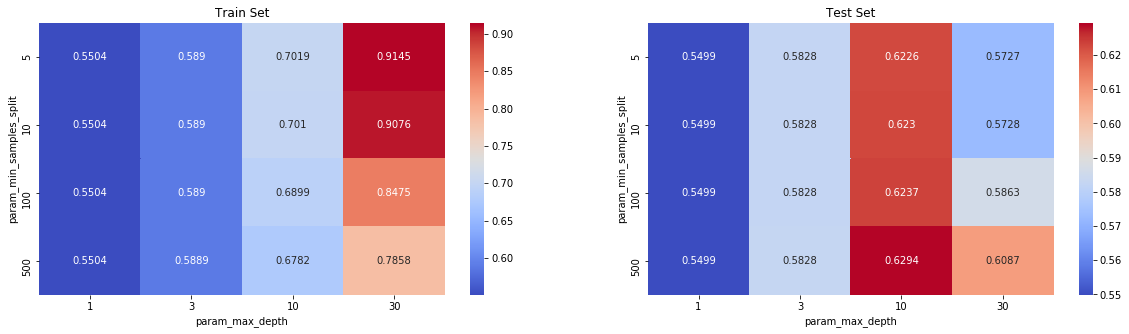

In [197]:
## https://www.geeksforgeeks.org/pandas-groupby-unstack/
## https://indianaiproduction.com/seaborn-heatmap/
## https://stackoverflow.com/questions/34162443/why-do-many-examples-use-fig-ax-plt-subplots-in-matplotlib-pyplot-python

param_max_depth= [1, 3, 10, 30]
param_min_samples_split = [5, 10, 100, 500]

scores1 = pd.DataFrame(GCV.cv_results_).groupby(['param_min_samples_split', 'param_max_depth']).max().unstack()[['mean_test_score', 'mean_train_score']]
fig,ax = plt.subplots(1,2, figsize=(20,5))

sns.heatmap(scores1.mean_train_score, annot = True, fmt='.4g', ax=ax[0],cmap='coolwarm')
sns.heatmap(scores1.mean_test_score, annot = True, fmt='.4g', ax=ax[1],cmap='coolwarm')

ax[0].set_title('Train Set')
ax[1].set_title('Test Set')
plt.show()

### ROC-AUC Curve:

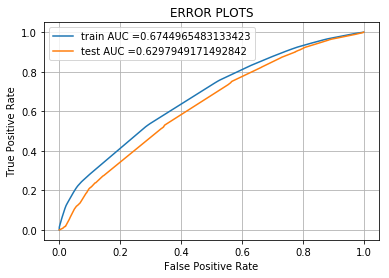

In [114]:
Dtree1 = tree.DecisionTreeClassifier(class_weight ="balanced",max_depth=10,min_samples_split=500)
Dtree1.fit(X_train_set1,y_train)


pred_ytrain1 = Dtree1.predict_proba(X_train_set1) [:,1]
pred_ytest1 = Dtree1.predict_proba(X_test_set1) [:,1]


trfpr1, trtpr1, trthres1 = roc_curve(y_train, pred_ytrain1)
tfpr1, ttpr1, tthres1 = roc_curve(y_test, pred_ytest1)

plt.plot(trfpr1, trtpr1, label="train AUC ="+str(auc(trfpr1,trtpr1)))
plt.plot(tfpr1, ttpr1, label="test AUC ="+str(auc(tfpr1,ttpr1)))
plt.legend()
plt.grid()
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ERROR PLOTS")
plt.show()

### Confusion Matrix:

In [115]:
def best_threshold(threshold, fpr, tpr):
    th = threshold[np.argmax(tpr*(1-fpr))]
    print("the maximum value", max(tpr*(1-fpr)), "for threshold", np.round(th,3))
    return th

In [116]:
def predict(prob, threshold):
    predictions = []
    for i in prob:
        if i>=threshold:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions

the maximum value 0.3775377236906596 for threshold 0.51
CONFUSION MATRIX OF TRAIN DATA
[[ 7769  3314]
 [28660 33453]]


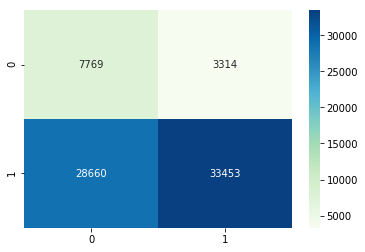

In [117]:
best_thres = best_threshold(trthres1, trfpr1, trtpr1)
conf_mat=metrics.confusion_matrix(y_train,predict(pred_ytrain1,best_thres))

print("CONFUSION MATRIX OF TRAIN DATA")
print(conf_mat)
sns.heatmap(conf_mat, annot=True, fmt='d',cmap='GnBu')

the maximum value 0.34672685074325577 for threshold 0.51
CONFUSION MATRIX OF TRAIN DATA
[[ 3563  1896]
 [14341 16252]]


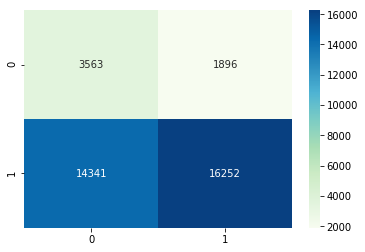

In [118]:
best_thres1 = best_threshold(tthres1,tfpr1, ttpr1)
conf_mat1=metrics.confusion_matrix(y_test,predict(pred_ytest1,best_thres1))

print("CONFUSION MATRIX OF TRAIN DATA")
print(conf_mat1)
sns.heatmap(conf_mat1, annot=True, fmt='d',cmap='GnBu')

### False positive data:

In [119]:
## https://datascience.stackexchange.com/questions/97499/viewing-false-positive-rows-in-python

predictfp=predict(pred_ytest1,best_thres1)
fp = []
for i in range(len(y_test)):
    if(y_test[i]==0) & (predictfp[i] == 1):
        fp.append(i) 
len(fp)

1896

### Wordcloud:

In [120]:
!pip install wordcloud

In [200]:
cols = X_test.columns
X_testfp = pd.DataFrame(columns=cols) 
X_testfp=X_test.iloc[fp,:]    

In [122]:
##  #https://www.geeksforgeeks.org/generating-word-cloud-python/


from wordcloud import WordCloud, STOPWORDS 
comment_words = ' '
stopwords = set(STOPWORDS)
for word in X_testfp['essay']:
    val = str(word)               
    tokens = val.split()
    for i in range(len(tokens)):
        tokens[i] = tokens[i].lower()
    for words in tokens:
        comment_words = comment_words + words + ' '

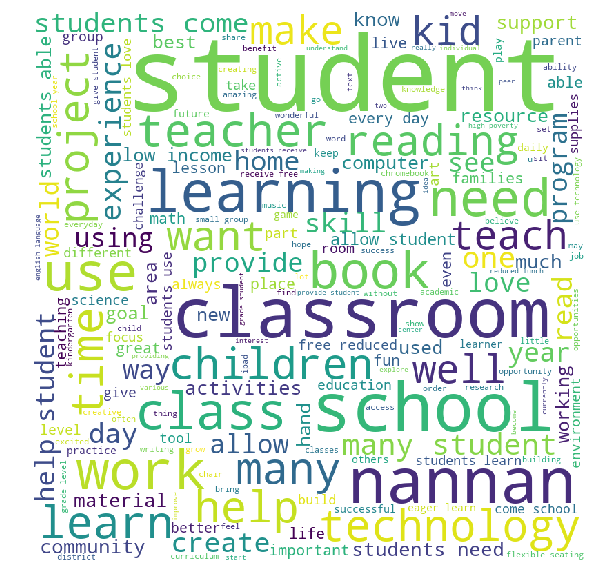

In [123]:
### https://www.analyticsvidhya.com/blog/2020/10/word-cloud-or-tag-cloud-in-python/


wordcloud = WordCloud(width = 800, height = 800, background_color ='white', stopwords = stopwords, min_font_size = 10).generate(comment_words)

plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

### PDF for teachers previous posted projects:

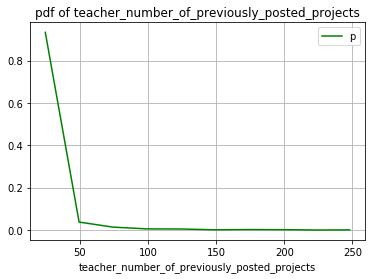

In [124]:
## https://www.geeksforgeeks.org/how-to-calculate-and-plot-a-cumulative-distribution-function-with-matplotlib-in-python/

counts, bin_edges = np.histogram(X_testfp['teacher_number_of_previously_posted_projects'], bins=10,density = True)
pdf = counts/(sum(counts))
#cdf = np.cumsum(pdf)
plt.plot(bin_edges[1:],pdf,color="green")
plt.legend("pdf")
plt.title("pdf of teacher_number_of_previously_posted_projects")
plt.xlabel('teacher_number_of_previously_posted_projects')
plt.grid()

### Box Plot

Text(0.5,1,'box plot')

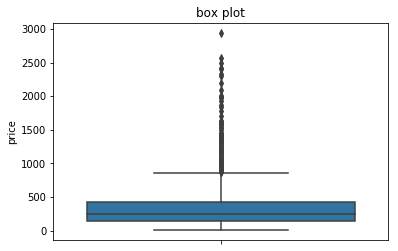

In [125]:
sns.boxplot(y='price', data=X_testfp).set_title("box plot")

## SET 2:

### Model implementation:

In [165]:
Dtree2 = tree.DecisionTreeClassifier(class_weight ="balanced")
params={"max_depth":[1, 3, 10, 30],"min_samples_split":[5, 10, 100, 500]}
GCV1 = GridSearchCV(Dtree2,params,cv=5,return_train_score=True,scoring='roc_auc',n_jobs=-1)
GCV1.fit(X_train_set2,y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(class_weight='balanced'),
             n_jobs=-1,
             param_grid={'max_depth': [1, 3, 10, 30],
                         'min_samples_split': [5, 10, 100, 500]},
             return_train_score=True, scoring='roc_auc')

### Best parameters:

In [174]:
trainauc= GCV1.cv_results_['mean_train_score']
trainaucstd= GCV1.cv_results_['std_train_score']
cvauc = GCV1.cv_results_['mean_test_score'] 
cvaucstd= GCV1.cv_results_['std_test_score']

print('score: ',GCV1.best_score_)
print('Hyper params: ',GCV1.best_params_)

score:  0.6079461606091183
Hyper params:  {'max_depth': 10, 'min_samples_split': 500}


### Heat map:

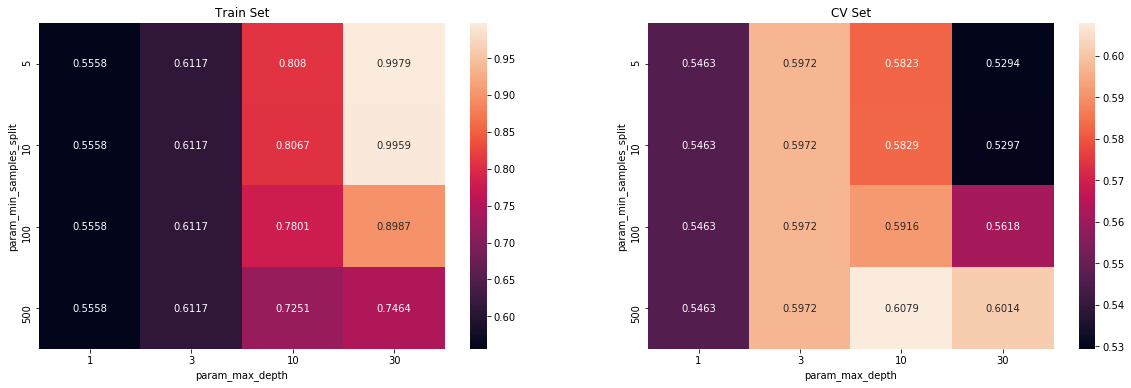

In [181]:
## https://www.geeksforgeeks.org/pandas-groupby-unstack/
## https://indianaiproduction.com/seaborn-heatmap/
## https://stackoverflow.com/questions/34162443/why-do-many-examples-use-fig-ax-plt-subplots-in-matplotlib-pyplot-python

param_max_depth= [1, 3, 10, 30]
param_min_samples_split = [5, 10, 100, 500]

scores2 = pd.DataFrame(GCV1.cv_results_).groupby(['param_min_samples_split', 'param_max_depth']).max().unstack()[['mean_test_score', 'mean_train_score']]
fig, ax = plt.subplots(1,2, figsize=(20,6))

sns.heatmap(scores2.mean_train_score, annot = True, fmt='.4g', ax=ax[0],cmap='coolwarm')
sns.heatmap(scores2.mean_test_score, annot = True, fmt='.4g', ax=ax[1],cmap='coolwarm')
ax[1].set_title('Test Set')
ax[0].set_title('Train Set')

plt.show()

### ROC_AUC plot:

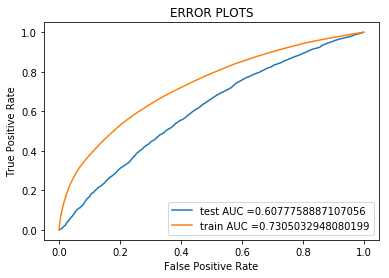

In [180]:
Dtree3 = tree.DecisionTreeClassifier(class_weight ="balanced",max_depth=10,min_samples_split=500)
Dtree3.fit(X_train_set2,y_train)


pred_ytrain2 = Dtree3.predict_proba(X_train_set2) [:,1]
trfpr2, trtpr2, trthres2 = roc_curve(y_train, pred_ytrain2)


pred_ytest2 = Dtree3.predict_proba(X_test_set2) [:,1]
tfpr2, ttpr2, tthres2 = roc_curve(y_test, pred_ytest2)

plt.plot(tfpr2, ttpr2, label="test AUC ="+str(auc(tfpr2, ttpr2)))
plt.plot(trfpr2, trtpr2, label="train AUC ="+str(auc(trfpr2, trtpr2)))


plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.title("ERROR PLOTS")
plt.show()

### Confusion Matrix:

the maximum value 0.44616458197673936 for threshold 0.487
CONFUSION MATRIX OF TRAIN DATA
[[ 7579  3504]
 [21588 40525]]


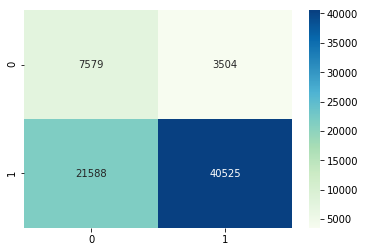

In [169]:
best_thres2 = best_threshold(trthres2, trfpr2, trtpr2)
conf_mat2=metrics.confusion_matrix(y_train,predict(pred_ytrain2,best_thres2))

print("CONFUSION MATRIX OF TRAIN DATA")
print(conf_mat2)
sns.heatmap(conf_mat2, annot=True, fmt='d',cmap='GnBu')

the maximum value 0.3367437893556042 for threshold 0.489
CONFUSION MATRIX OF TRAIN DATA
[[ 3027  2432]
 [12014 18579]]


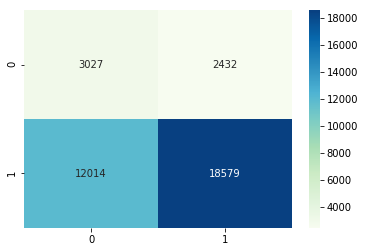

In [170]:
best_thres3 = best_threshold(tthres2,tfpr2, ttpr2)
conf_mat3=metrics.confusion_matrix(y_test,predict(pred_ytest2,best_thres3))

print("CONFUSION MATRIX OF TRAIN DATA")
print(conf_mat3)
sns.heatmap(conf_mat3, annot=True, fmt='d',cmap='GnBu')

### False Positive values:

In [171]:
## https://datascience.stackexchange.com/questions/97499/viewing-false-positive-rows-in-python

predictfp1=predict(pred_ytest2,best_thres3)
fp1 = []
for i in range(len(y_test)):
    if(y_test[i]==0) & (predictfp1[i] == 1):
        fp1.append(i) # GETTING THE ALL FALSE POSITIVE INDICES


In [199]:
cols1 = X_test.columns
X_testfp1 = pd.DataFrame(columns=cols1) # MAKING THE FALSE POSITIVE DATAFRAME
X_testfp1=X_test.iloc[fp1,:]    

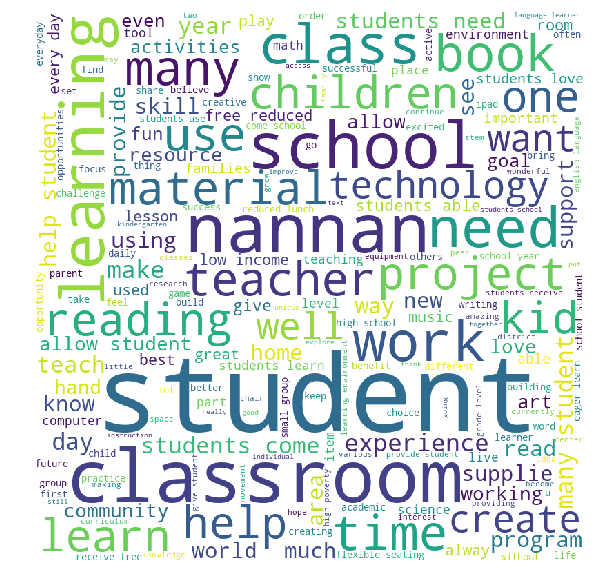

In [173]:
 #https://www.geeksforgeeks.org/generating-word-cloud-python/

from wordcloud import WordCloud, STOPWORDS 
comment_words = ' '
stopwords = set(STOPWORDS)
for word in X_testfp1['essay']:
    val = str(word)               
    tokens = val.split()
    for i in range(len(tokens)):
        tokens[i] = tokens[i].lower()
    for sen in tokens:
        comment_words = comment_words + sen + ' '

## https://www.analyticsvidhya.com/blog/2020/10/word-cloud-or-tag-cloud-in-python/        
wordcloud1 = WordCloud(width = 800, height = 800, background_color ='white', stopwords = stopwords, min_font_size = 10).generate(comment_words)

plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud1) 
plt.axis("off") 
plt.tight_layout(pad = 0)   
plt.show() 

### PDF of  teacher_number_of_previously_posted_projects:

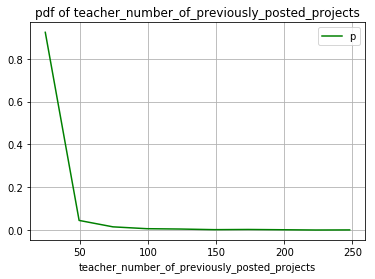

In [135]:
## https://www.geeksforgeeks.org/how-to-calculate-and-plot-a-cumulative-distribution-function-with-matplotlib-in-python/

counts, bin_edges = np.histogram(X_testfp1['teacher_number_of_previously_posted_projects'], bins=10,density = True)
pdf = counts/(sum(counts))
#cdf = np.cumsum(pdf)
plt.plot(bin_edges[1:],pdf,color="green")
plt.legend("pdf")
plt.title("pdf of teacher_number_of_previously_posted_projects")
plt.xlabel('teacher_previously_posted_projects')
plt.grid()

### Box plot:

Text(0.5,1,'box plot')

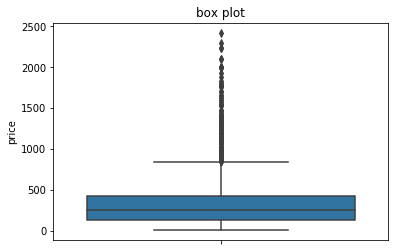

In [136]:
sns.boxplot(y='price', data=X_testfp1).set_title("box plot")

# Task 2:

In [147]:
from scipy.sparse import hstack
X_train_set3=hstack((X_train_state_transform, \
                   X_train_prefix_transform, \
                   X_train_grade_transform, \
                   X_train_categories_transform, \
                   X_train_sub_transform, \
                   X_train_price_transform, \
                   X_train_prev_transform, \
                   X_train_essay, \
                   X_train_compound, \
                    X_train_neu, \
                    X_train_pos, \
                    X_train_neg)).tocsr()
X_test_set3=hstack((X_test_state_transform, \
                   X_test_prefix_transform, \
                   X_test_grade_transform, \
                   X_test_categories_transform, \
                   X_test_sub_transform, \
                   X_test_price_transform, \
                   X_test_prev_transform, \
                   X_test_essay, \
                   X_test_compound, \
                   X_test_pos, \
                   X_test_neg, \
                   X_test_neu)).tocsr()

In [148]:
print(X_train_set3.shape)
print(X_test_set3.shape)

(73196, 5105)
(36052, 5105)


### Model implementation:

In [149]:
feat = tree.DecisionTreeClassifier(class_weight ="balanced",max_depth = None,min_samples_split = 500)

feat.fit(X_train_set3,y_train)

DecisionTreeClassifier(class_weight='balanced', min_samples_split=500)

### Selecting Non Zero Features:

In [150]:
## https://towardsdatascience.com/feature-importance-in-decision-trees-e9450120b445


feature= feat.feature_importances_
len(feature)
non_zero_features=[]
for i in range(len(feature)):
    if feature[i]>0:             
        non_zero_features.append(i)
        
print(len(non_zero_features))

1290


In [151]:
X_trainnzfeat=X_train_set3[:,non_zero_features]
X_testnzfeat=X_test_set3[:,non_zero_features]

In [152]:
from sklearn import tree
Dtree0 = tree.DecisionTreeClassifier(class_weight ="balanced")
from sklearn.model_selection import GridSearchCV
params={"max_depth":[1, 3, 10, 30],"min_samples_split":[5, 10, 100, 500]}
GCV0 = GridSearchCV(Dtree0,params,cv=5,return_train_score=True,scoring='roc_auc',n_jobs=-1)
GCV0.fit(X_trainnzfeat,y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(class_weight='balanced'),
             n_jobs=-1,
             param_grid={'max_depth': [1, 3, 10, 30],
                         'min_samples_split': [5, 10, 100, 500]},
             return_train_score=True, scoring='roc_auc')

### Best Parameters:

In [183]:
trainauc= GCV0.cv_results_['mean_train_score']
trainaucstd= GCV0.cv_results_['std_train_score']
cvauc = GCV0.cv_results_['mean_test_score'] 
cvaucstd= GCV0.cv_results_['std_test_score']
print('Best score: ',GCV0.best_score_)
print('Best Hyper parameters: ',GCV0.best_params_)

Best score:  0.6333731310875728
Best Hyper parameters:  {'max_depth': 10, 'min_samples_split': 500}


### Heat Maps:

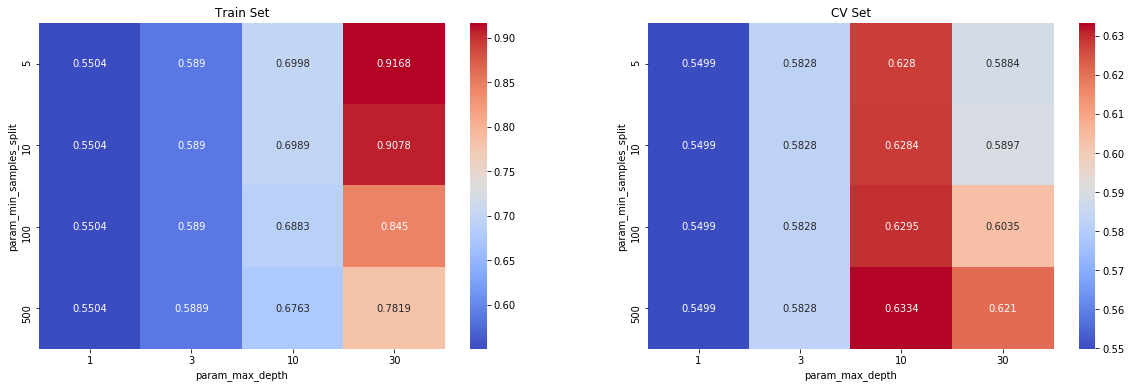

In [184]:
## https://www.geeksforgeeks.org/pandas-groupby-unstack/
## https://indianaiproduction.com/seaborn-heatmap/
## https://stackoverflow.com/questions/34162443/why-do-many-examples-use-fig-ax-plt-subplots-in-matplotlib-pyplot-python


param_max_depth= [1, 3, 10, 30]
param_min_samples_split = [5, 10, 100, 500]

scores0 = pd.DataFrame(GCV0.cv_results_).groupby(['param_min_samples_split', 'param_max_depth']).max().unstack()[['mean_test_score', 'mean_train_score']]
scores0
fig, ax = plt.subplots(1,2, figsize=(20,6))

sns.heatmap(scores0.mean_train_score, annot = True, fmt='.4g', ax=ax[0],cmap='coolwarm')
sns.heatmap(scores0.mean_test_score, annot = True, fmt='.4g', ax=ax[1],cmap='coolwarm')
ax[1].set_title('CV Set')
ax[0].set_title('Train Set')

plt.show()

### ROC_AUC Plot:

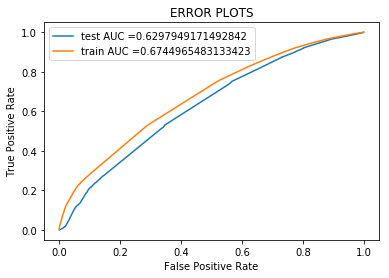

In [182]:
Dtree9 = tree.DecisionTreeClassifier(class_weight ="balanced",max_depth=10,min_samples_split=500)
Dtree9.fit(X_trainnzfeat,y_train)

pred_ytrain9 = Dtree9.predict_proba(X_trainnzfeat) [:,1]
train_fpr,train_tpr,train_thres = roc_curve(y_train, pred_ytrain9)

pred_ytest9 = Dtree9.predict_proba(X_testnzfeat) [:,1]
test_fpr,test_tpr,test_thres= roc_curve(y_test, pred_ytest9)

plt.plot(test_fpr,test_tpr, label="test AUC ="+str(auc(test_fpr,test_tpr)))
plt.plot(train_fpr,train_tpr, label="train AUC ="+str(auc(train_fpr,train_tpr)))

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ERROR PLOTS")
plt.legend()
plt.show()

### Confusion Matrix:

the maximum value 0.3775377236906596 for threshold 0.51
CONFUSION MATRIX OF TRAIN DATA
[[ 7769  3314]
 [28660 33453]]


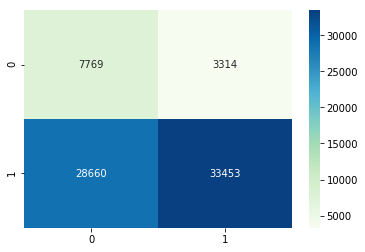

In [157]:
best_thres4 = best_threshold(trthres0, trfpr0, trtpr0)
conf_mat4=metrics.confusion_matrix(y_train,predict(pred_ytrain9,best_thres4))

print("CONFUSION MATRIX OF TRAIN DATA")
print(conf_mat4)
sns.heatmap(conf_mat4, annot=True, fmt='d',cmap='GnBu')

the maximum value 0.34672685074325577 for threshold 0.51
CONFUSION MATRIX OF TRAIN DATA
[[ 3563  1896]
 [14341 16252]]


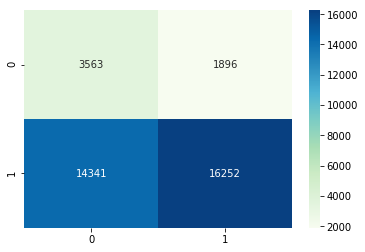

In [158]:
best_thres5 = best_threshold(tthres0,tfpr0, ttpr0)
conf_mat5=metrics.confusion_matrix(y_test,predict(pred_ytest9,best_thres5))

print("CONFUSION MATRIX OF TRAIN DATA")
print(conf_mat5)
sns.heatmap(conf_mat5, annot=True, fmt='d',cmap='GnBu')

### WordCloud:

In [159]:
## https://datascience.stackexchange.com/questions/97499/viewing-false-positive-rows-in-python

predictfp3=predict(pred_ytest9,best_thres5)

fp0 = []
for i in range(len(y_test)):
    if(y_test[i]==0) & (predictfp3[i] == 1):
        fp0.append(i) 

In [198]:
cols0 = X_test.columns
X_testfp0 = pd.DataFrame(columns=cols0)
X_testfp0=X_test.iloc[fp0,:]  

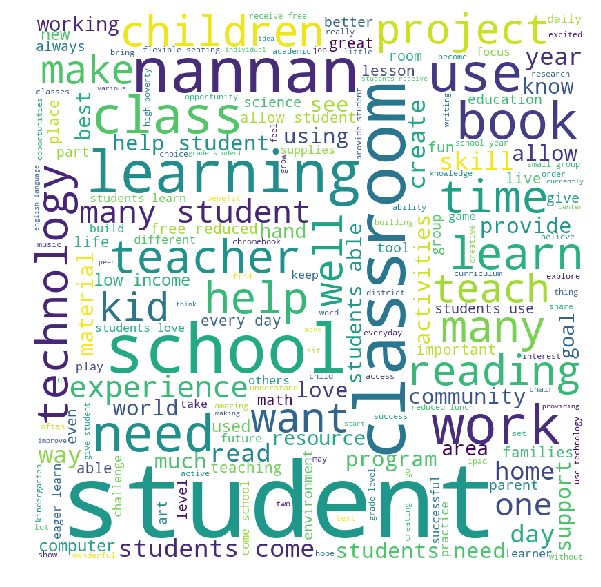

In [161]:
## #https://www.geeksforgeeks.org/generating-word-cloud-python/

from wordcloud import WordCloud, STOPWORDS 
comment_words = ' '
stopwords = set(STOPWORDS)
for word in X_testfp0['essay']:
    val = str(word)                
    tokens = val.split()
    for i in range(len(tokens)):
        tokens[i] = tokens[i].lower()
    for sen in tokens:
        comment_words = comment_words + sen + ' '

## https://www.analyticsvidhya.com/blog/2020/10/word-cloud-or-tag-cloud-in-python/   
wordcloud0 = WordCloud(width = 800, height = 800, background_color ='white', stopwords = stopwords, min_font_size = 10).generate(comment_words)

plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud0) 
plt.axis("off") 
plt.tight_layout(pad = 0)   
plt.show() 

### pdf of teacher_number_of_previously_posted_projects:

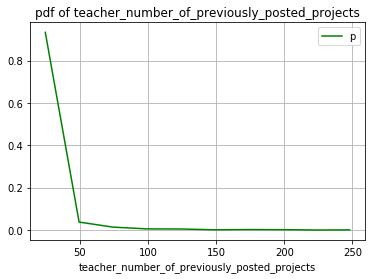

In [162]:
## https://www.geeksforgeeks.org/how-to-calculate-and-plot-a-cumulative-distribution-function-with-matplotlib-in-python/

counts, bin_edges = np.histogram(X_testfp0['teacher_number_of_previously_posted_projects'], bins=10,density = True)
pdf = counts/(sum(counts))
#cdf = np.cumsum(pdf)
plt.plot(bin_edges[1:],pdf,color="green")
plt.legend("pdf")
plt.title("pdf of teacher_number_of_previously_posted_projects")
plt.xlabel('teacher_number_of_previously_posted_projects')
plt.grid()

### BoxPlot:

Text(0.5,1,'box plot')

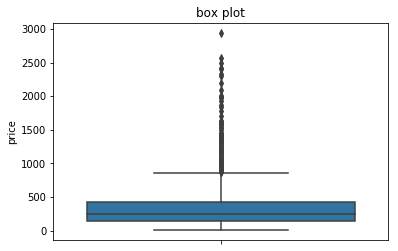

In [163]:
sns.boxplot(y='price', data=X_testfp0).set_title("box plot")

### Observations:

In [177]:
# http://zetcode.com/python/prettytable/

from prettytable import PrettyTable

x = PrettyTable()
x.field_names = ["Vectorizer", "Model", "Hyperparameters(max depth,min samples split)", "Test AUC"]

x.add_row(["TFIDF", "Decision Trees", "(10, 500)", 0.6285])
x.add_row(["TFIDF W2V", "Decision Trees", "(10, 500)", 0.607])
x.add_row(["TFIDF Non zero features", "Decision Trees", "(10,500)", 0.633])
print(x)

+-------------------------+----------------+----------------------------------------------+----------+
|        Vectorizer       |     Model      | Hyperparameters(max depth,min samples split) | Test AUC |
+-------------------------+----------------+----------------------------------------------+----------+
|          TFIDF          | Decision Trees |                  (10, 500)                   |  0.6285  |
|        TFIDF W2V        | Decision Trees |                  (10, 500)                   |  0.607   |
| TFIDF Non zero features | Decision Trees |                   (10,500)                   |  0.633   |
+-------------------------+----------------+----------------------------------------------+----------+
